# Introduction

Last week, we thought about models of hetereogeneity. They let us develop more realistic interpretations of experiments. But they come with extra complications, namely, now do we estimate models with two or more parameters? Today, you'll learn about Monte Carlo Markov Chains and how they help us scale up Bayesian techniques to multi-parameter (also called high dimensional) problems.

## Refresh on Beta-binomial

In the last lecture, we noticed a number of inadequacies with the binomial model. One assumption we took particular issue was the assumption that everybody in a group has the same rate of errors. If we pay attention to the interview information from Asch, this assumption is clearly bad. People in the treatment group have at least 2 (potentially 6) different reactions to the experiment. 

We started trying to model this with a mixture of two binomial distribution. One trouble with the mixture is picking the right number of groups. The other problem is that we get an explosion of free parameters which can make estimation hard. Two groups gives us three parameters. If we want a mixture of more than two groups, it gets really complicated.

Fortunately, there is a more elegant solution, the beta-binomial model. It imagines that error rates can vary from person to person. But the amount of variation is described by a beta distribution. 

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def simulate_experiment(a,b,n=12):

    data = []

    for i in range(1000):
        
        p = stats.beta(a=a,b=b).rvs()
            
        errors = stats.binom(p=p,n=n).rvs()
            
        data.append(errors)

    return data

Here is the plotted probability distribution.

<BarContainer object of 13 artists>

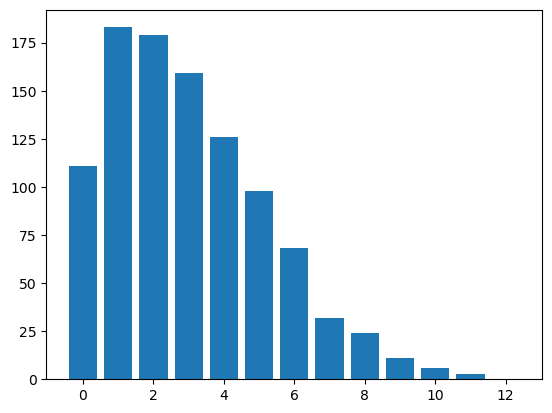

In [2]:
data = simulate_experiment(a=2,b=6,n=12)
outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = data.count(i)
    counts.append(matches)
    
# plotting structure

plt.bar(outcomes,counts)

### Two ways to think about the parameters of the beta distribution

I must confess that thinking in terms of a and b parameters is pretty hard. There is a mathematical equivalent way of expressing the distribution. We can use two parameters that are a lot easier to think about:

- p = the center
- d = the spread

The way the equivalence works is that `p` controls how much weight is assigned to `a` or `b` and `d` controls how much that weight matters.

$$a = p*d$$
$$b = (1-p)*d$$

So for example, when `d` is very small (like 10 or less) then it is like plugging in small numbers to `a` and `b`. You tend to get very flat distributions and where they concentrate is just controlled by `p`. Below I've plotted the same beta distribution but using both parameterizations of it.

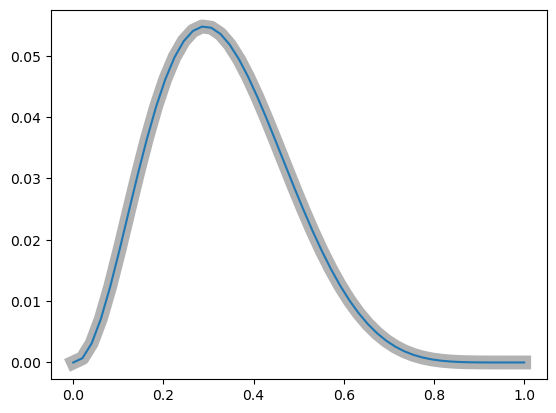

In [3]:
x = np.linspace(0,1)

p = 0.333
d = 10

y1 = stats.beta(a=p*d,b=(1-p)*d).pdf(x)
y1 = y1 / sum(y1)
y2 = stats.beta(a=3.33,b=6.666).pdf(x)
y2 = y2 / sum(y2)

plt.plot(x,y1,'-',linewidth=10,alpha=0.3,color="black")
plt.plot(x,y2,'-')

When `d` is very big, then it's like putting in very big values for `a` and `b`. You get skinny distributions.

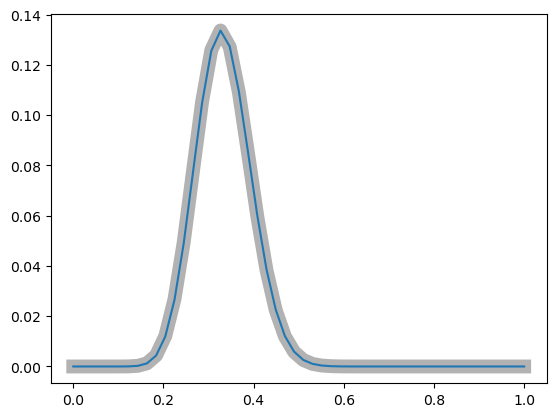

In [4]:
x = np.linspace(0,1)

p = 0.333
d = 60

y1 = stats.beta(a=p*d,b=(1-p)*d).pdf(x)
y1 = y1 / sum(y1)
y2 = stats.beta(a=20,b=40).pdf(x)
y2 = y2 / sum(y2)

plt.plot(x,y1,'-',linewidth=10,alpha=0.3,color="black")
plt.plot(x,y2,'-')

The beta-binomial distribution solves both our problems with the two category mixture model. First, it only has two parameters. Moreover, `scipy.stats` has a convenient function available so we can make our estimation go fast. Second, it doesn't assume a fixed number of groups. Here is an example of how the `stats.betabinom` distribution works.

Finally, here is the probability distribution again but using our new parameterization. Play around with this cell to get a feel for what different `p` and `d` parameter imply at the level of the outcomes.

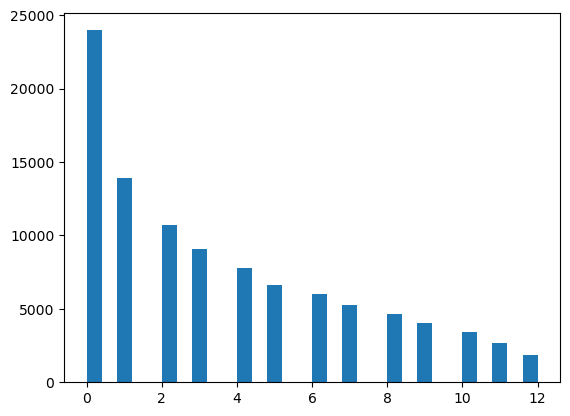

In [5]:
p = 0.3
d = 2
p = stats.betabinom(a=p*d,b=(1-p)*d,n=12).rvs(100000)
plt.hist(p,bins=30);

# Estimation

The final step in our modeling workflow is to estimate our model. What parameters of `p` and `d` are most consistent with the observed data? Let's pull out the data again. 

It will turn out that estimating the parameters is no trivial task. We'll discover we have to rely on a very unusual algorithm to pull this off. My goal in this class is to focus on scientific modeling, rather than spending a lot of time teaching machine learning algorithms. So you'll just get a conceptual introduction to something known as the *monte carlo markov chain* but we'll use a package to handle the technical details for us. To build up to that, we'll need to think about estimation in a number of small steps.

In [6]:
import pandas as pd

url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"

data = pd.read_csv(url)
data

,treatment,mistakes
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
82,0,0
83,0,0
84,0,0
85,0,1


We'll use the same filtering technique. This time we have to convert our output to a list so it works with our counting code below.

In [9]:
n = 12

# treatment group

data_treatment = data[data.treatment == 1]
k_treatment = list(data_treatment.mistakes.values)

# control group

data_control = data[data.treatment == 0]
k_control = list(data_control.mistakes.values)

## Estimating-by-hand

One way to get a feel for how well different parameters fit the data is to just adjust the parameters by hand. Below I've built a simple widget that gives you sliders to control `p` and `d`. You don't need to worry about how the code work for the widget. Just score down and click the button. It plots the observed data alongside the probability distribution implied by our beta-binomial model. It also reports a likelihood score that quantifies how well the distribution fits the data. 

The likelihood score is on a log scale so it looks negative. The closer to zero the score goes, the better the fit to the data. (If that didn't make any sense, try taking the log of a probability like 0.99. Then try taking the log of 0.0001). Spend some time adjusting the sliders to see what parameters fit the data best.

In [35]:
import ipywidgets as widgets

def draw_betabinom(p,d,n,k):
    
    # do the
    
    x = np.arange(0,n+1)
    
    counts = []

    for i in x:
        matches = k.count(i) / len(k)
        counts.append(matches)
    
    likelihood = stats.betabinom(n=n,a=p*d,b=(1-p)*d).logpmf(k)
    print(np.sum(likelihood))
    
    y = stats.betabinom(n=n,a=p*d,b=(1-p)*d).pmf(x)
    
    plt.bar(x,counts,alpha=1,color="grey",label="data")
    plt.bar(x,y,color="tab:blue",alpha=0.5,label="model")
    plt.legend()

widgets.interact_manual(draw_betabinom,
                 p=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 d=widgets.IntSlider(min=2, max=100, step=1, value=50),
                 n=widgets.fixed(12),
                 k=widgets.fixed(k_treatment))

interactive(children=(FloatSlider(value=0.5, description='p', max=1.0, step=0.01), IntSlider(value=50, descrip…

<function __main__.draw_betabinom(p, d, n, k)>

Same thing for the control group.

In [29]:
widgets.interact_manual(draw_betabinom,
                 p=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 d=widgets.IntSlider(min=2, max=100, step=1, value=50),
                 n=widgets.fixed(12),
                 k=widgets.fixed(k_control))

interactive(children=(FloatSlider(value=0.5, description='p', max=1.0, step=0.01), IntSlider(value=50, descrip…

<function __main__.draw_betabinom(p, d, n, k)>

Two key insight from this exercise. First, the `p` and `d` parameters interact. Whether a certain `p` value fits the data well depends on `d` value. Adjusting the `d` value can make turn a poorly performing `p` parameter into a good one. In more complex models, these interactions can get very complicated which is why hand exploration of the model is really helpful for understanding what it implies.

Second, small adjustments in the `d` value have a big influence on the fit when we are exploring the low end of the scale (d = 2-30). But when we are exploring the high end of the scale, small adjustments in the `d` value have very little influence on the score. For example, `d = 80` vs `d = 85` has a very small impact on the likelihood. This arises because once d is large, the distribution is approximately binomial. Making the distribution even more binomial cannot have a very big impact.

All estimation algorithms have to solve the same kind of problem you just studied by hand. What is the best procedure to adjust the parameters to explore the likelihood? 

- **Grid approximation**: They might try out every combination of values on both sliders. This has the benefit of giving you a comprehensive picture of the likelihood distribution. But it can become incredibly slow. If you try a fine-grained grid, your approximation gets better but your compute time goes way up. This becomes especially problematic if you have three or more parameters. It seems like it would be smarter to spend more our computing time only looking at *interesting* areas of the likelihood distribution.

- **Cyclical optimization**: You might adjust one slider to find the best value. Then switch to the other slider and adjust until you find the best value. Then switch back to the first slider and explore it again. Keep rotating through the sliders until no adjustment can improve the fit. This is faster but you don't get as comprehensive a picture of the likelihood distribution. It is hard to get a sense of uncertainty if we are only looking for the best values, rather than the second best or third best values. There are a bunch of optimization algorithms but all do a poor job of telling us about uncertainty.

- **The Monte Carlo Markov Chain**: What if we could do both - spend most of our time looking at the interesting regions of the distribution but also explore the uncertainty?

## pymc and the monte carlo markov chain (MCMC)

I'll introduce monte carlo markov chain with a parable. Imagine a skateboard park with a massive bowl at the center. The skateboard park has been carefully measured so we have a grid of x and y coordinates that covers each point in the park. Also imagine there is no friction. A skateboarder rides around the bowl for an hour or so. Every few seconds, an aerial drone stationed directly above the bowl takes a snapshot of the skateboarder. Thousands of snapshots are recorded. In each one, we record the x and y coordinates of the skateboarder. After the hour is over, we compile a list of all the x and y coordinates.

In this parable, the depth of the bowl represents areas with high likelihood. The location of the skateboard with respect to x and y represents two different parameter values, perhaps `p` is on one axis and `d` is on another. It turns out that the frequency distribution of locations will perfectly correspond to the depth of the bowl. Or, simply, the skateboarder will get their picture taken most often when they are in the center of the bowl. They will get their picture taken fairly often in the region between the edge and the center. And they will get their picture taken least often at the rim. Why? Well, they are usually only at the rim for a split second before they turn around and go back. But quite often they are flying through the center of the bowl. The laws of gravity and momentum help ensure this is true. Here you can watch a particular version of the MCMC (the Hamiltonian) algorithm working on a bowl shaped distribution.

https://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=standard

Okay how does this wacky parable help us? Well, it means we only need a finite number of snapshots to get a good approximation of the posterior distribution. As we add more parameters to model, the number of snapshots doesn't grow out of control. Instead of exploring every possible combination of values, we spend more of our time looking at the interesting values (those close to the center). But instead of only looking for the best, we also spend some time exploring the values at the edges (to get a sense of uncertainty).

Designing and implementing monte carlo markov chain algorithms is really tough. So we've handed that work off to a package called pymc. Here is how to use it:

### Old lady tasting tea problem in pymc

We import it like this:

In [36]:
import pymc as pm

We feed pymc our prior and our likelihood function using a `with pm.Model as NAME_OF_MODEL`. Notice the indentation. The `with` structure is a way of grouping a bunch of information under a single object, this time called `model_0`.

In [37]:
with pm.Model() as model_0:
    
    # --priors--
    # uniform is another name for a flat prior
    # that assigns equal probability to every p in
    # between 0 and 1.
    
    p = pm.Uniform('p',lower=0,upper=1)
    
    # --likelihood--
    # this the pymc syntax equivalent for stats.binom
    # n is still n
    # p is still p
    # but k has been replaced with 'observed'
    
    y = pm.Binomial('y',n=8,p=p,observed=6)

You can run the cell with just this information in it to see if everything is well defined. Notice that this is the same Bayesian estimation of the lady tasting tea from before. But we only really need two lines of code to express it: the prior and the likelihood. No need to define a grid. No need to manually normalize things.

In [ ]:
with pm.Model() as model_0:
    
    # --priors--
    # uniform is another name for a flat prior
    # that assigns equal probability to every p in
    # between 0 and 1.
    
    p = pm.Uniform('p',lower=0,upper=1)
    
    # --likelihood--
    # this the pymc syntax equivalent for stats.binom
    # n is still n
    # p is still p
    # but k has been replaced with 'observed'
    
    y = pm.Binomial('y',n=8,p=p,observed=6)
    
    # estimation algorithm
    # pm.sample() just uses all the default settings
    # the package automatically detects which
    # estimation algorithm will work for your model
    # and tunes the algorithm for best performance
    # rarely, if ever, should use anything but the default settings
    
    trace = pm.sample()

Once we check to make sure our model is well-defined, we can do `trace = pm.sample()`. `trace` is the name of the object we store all the information into once we want to analyze the results later. `pm.sample()` is the command to activate the monte carlo markov chain. It will usually call it "NUTS" which is a small class of monte carlo markov chain that works great on nearly every type of Bayesian problem.

Finally, we have a plotting package called arviz which works well for Bayesian models. `plot_posterior` is the main command you'll want.

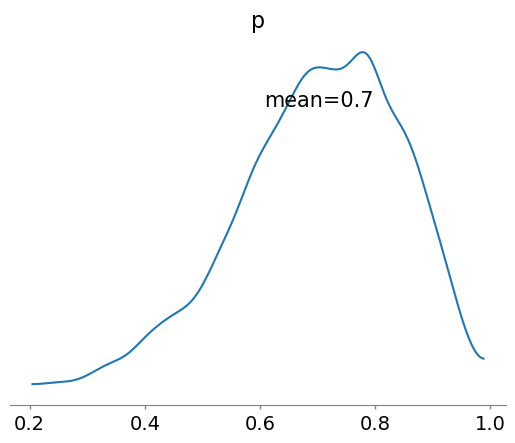

In [13]:
import arviz as az

az.plot_posterior(trace,hdi_prob='hide');

This should look familiar - it's the same posterior distribution chart we got from the grid approximation algorithm.

### Adjusting priors

We can easily adjust our priors using this software. Here is an example.

In [14]:
with pm.Model() as m1:
    
    # you can play around with different priors
    # I switched out the uniform distribution for a beta
    # that puts more credibility toward medium values of p
    # and less credibility to extreme values of p
    
    p = pm.Beta('p',alpha=3,beta=3)
    
    y = pm.Binomial('y',n=8,p=p,observed=6)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


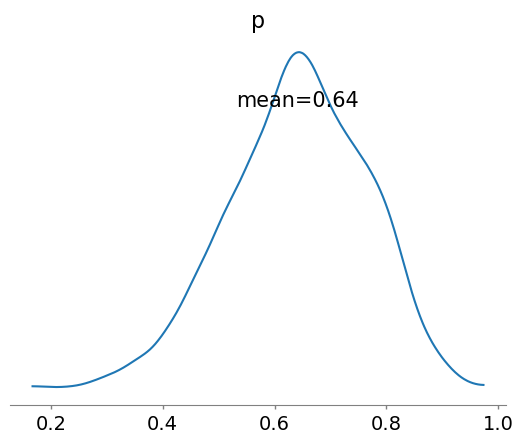

In [15]:
az.plot_posterior(trace,hdi_prob='hide');

# Back to heterogeneity

Okay that completes our journey through the theory of estimation. Now we need to apply all these tools to our model of heterogeneity. Let's think about priors for this model. Here is a grid and prior for `p`. We've already discussed `p` at length in other contexts so let's just leave it flat for the moment.

In [63]:
# grids

p_grid = np.linspace(0.01,0.99,200)
d_grid = np.linspace(1,500,500)

# priors

p_prior = np.ones(200) / 200

`d` is tricker. We know that it ranges from 1 - infinity. But which values are most plausible? Well, one fact helps us. Earlier in lecture, we noticed that the d parameter has very little impact on the likelihood after it gets very large. There is little difference between `d=100` and `d=120`. In fact, once it hits around 120, it's almost entirely binomial and every value after that is also binomial.

What this means is that we can discount very high values of `d`. Not because they are implausible. But because they are redundant. This also means a flat prior over dispersion would be a bad choice - you cannot actually have a flat prior. If you assigned all high values of `d` from 100 to infinity equal probability, then you would basically be assuming there is no dispersion.

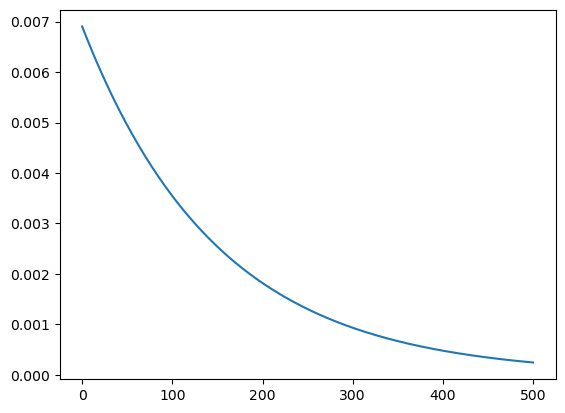

In [62]:
d_prior = stats.expon(0,scale=150).pdf(d_grid)
d_prior = d_prior / sum(d_prior)

plt.plot(d_grid,d_prior)

In [65]:
sum(d_prior[:100]),sum(d_prior[100:]) 

# the probability mass of stuff before 120
# the probaiblity mass of stuff after 120

(0.5051697923938648, 0.4948302076061357)

These two numbers tell us what proportion of probability is assigned below 120 and above 120. They are fairly similar. So this prior, although it looks like it favours high hetereogeneity, actually gives high and low hetereogeneity fairly equal chances.

Another way of helping your think about your priors is to visualize the joint interaction between them by sampling a large 10 or so pairs of parameters using `np.random.choice` and plotting them together. This chart reveals a small samples of what we think the distribution could look like, prior to the data.

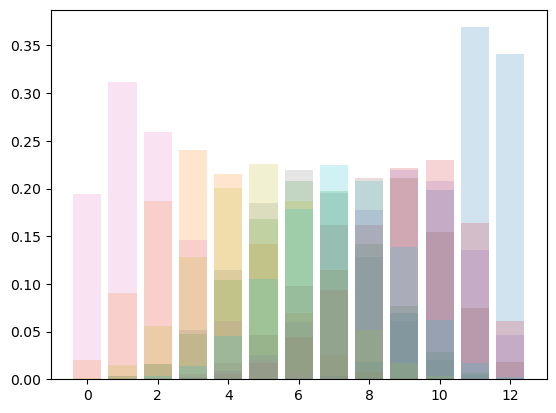

In [69]:
x = np.arange(0,13)

for i in range(10):
    d = np.random.choice(d_grid,p=d_prior)
    p = np.random.choice(p_grid,p=p_prior)
    
    y = stats.betabinom(n=12,a=p*d,b=(1-p)*d).pmf(x)
    y = y / sum(y)
    
    plt.bar(x,y,alpha=0.2)

## Beta-binomial model in pymc

Once we are happy with our choice of prior, we can program the model into pymc.

In [70]:
with pm.Model() as m2:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1   # annoyingly, pymc uses the inverse parameter for the expontential distribution
                                        # so if you want a mean of 150, you need to input 1 / 150. 
    
                                        # the plus 1 ensures d is always 1 or bigger. 
                                        # If d is between 0 and 1, the betabinomial
                                        # explodes because it implies nearly infinite dispersion.
            
    # we can keep our code tidy by doing the parameter conversions
    # outside our main functions
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=k_treatment)
    
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


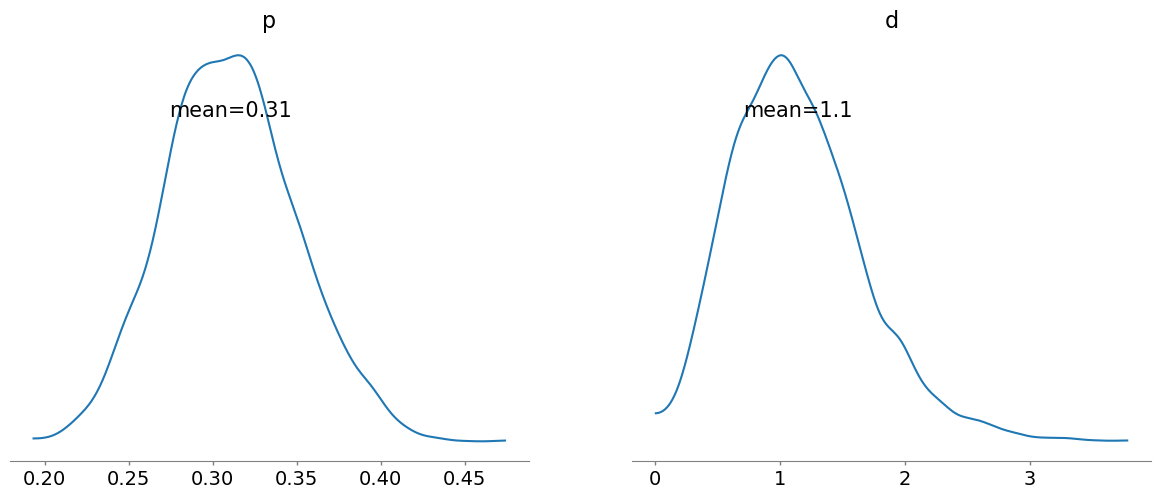

In [71]:
az.plot_posterior(trace2,hdi_prob='hide');

So these posterior charts tell two things: First, the mostly like `p` parameters are around 0.3. That is what we got with the old model. Second, the dispersion is quite high, between 0 and 3. If you remember from playing with the model by hand, that means it is extremely spread out. If you go back to the hand-fitting widget, you can visualize what the best performing distribution looks like (`p=0.31, d=1`) against the data.

Now we can work through the control group just by swapping out the `observed=` argument.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


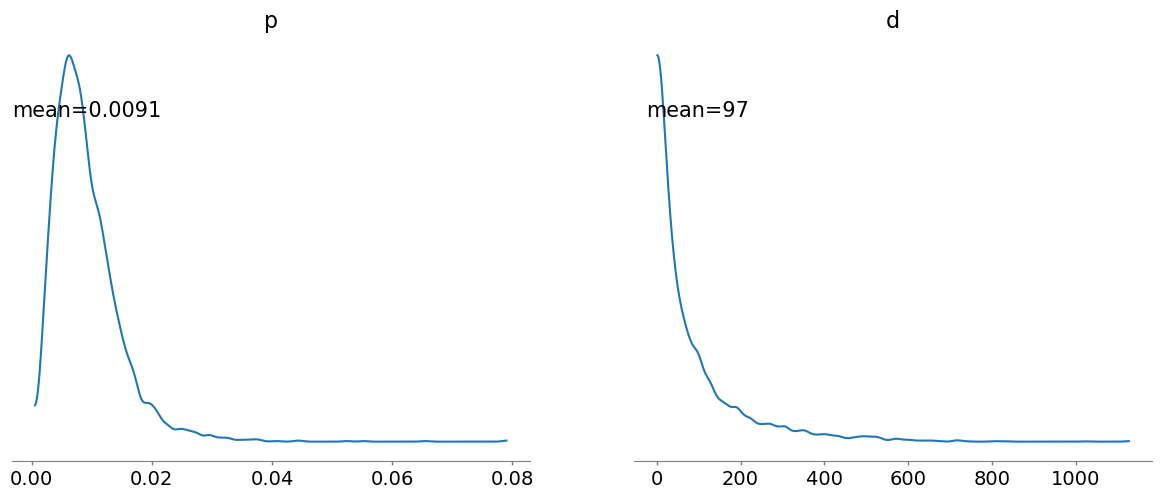

In [73]:
with pm.Model() as m3:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=k_control)
    
    trace3 = pm.sample()
    
az.plot_posterior(trace3,hdi_prob='hide');

The big contrast is that the dispersion parameter is fairly large - the mean is nearly 100 and even values as high as 400 are visable on the graph, suggesting very little dispersion for this group. It looks like that for visual accuracy tests, most people perform pretty much the same way.

## Posterior predictive comparison

One final step. We need to extract predictions so we can easily compare the two groups. To get samples of parameters from the posterior distribution, we can us this.

In [74]:
trace3.posterior['p'].values.flatten()

array([0.02789661, 0.01086136, 0.00729779, ..., 0.00560966, 0.00415294,
       0.00219285])

The output is a long list of `p` parameters where frequency of each `p` corresponds to the posterior distribution. To illustrate, compare this histogram to the `az.plot_posterior` above.

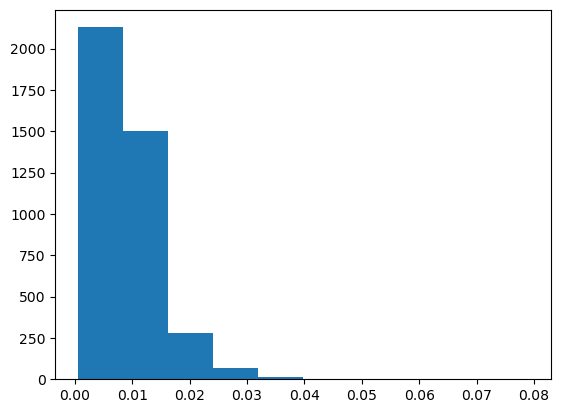

In [76]:
plt.hist(trace3.posterior['p'].values.flatten());

Once we extract them from the trace, we just plug them into `stats.betabinom.rvs()` to get predictions. We repeat the procedure from last week to compare differences in predictions.

In [20]:
p_control = trace3.posterior['p'].values.flatten()
d_control = trace3.posterior['d'].values.flatten()

p_treatment = trace2.posterior['p'].values.flatten()
d_treatment = trace2.posterior['d'].values.flatten()

predictions_control = stats.betabinom(a=p_control*d_control,b=(1-p_control)*d_control,n=12).rvs()
predictions_treatment = stats.betabinom(a=p_treatment*d_treatment,b=(1-p_treatment)*d_treatment,n=12).rvs()

(array([3.927e+03, 5.100e+01, 1.100e+01, 4.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

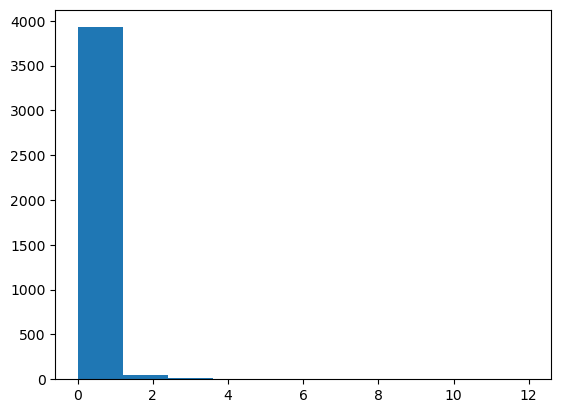

In [21]:
plt.hist(predictions_control)

(array([1892.,  320.,  259.,  195.,  160.,  314.,  135.,  154.,  158.,
         413.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

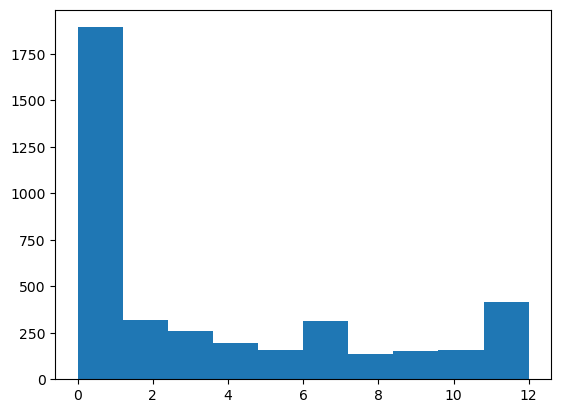

In [22]:
plt.hist(predictions_treatment)

0.001494

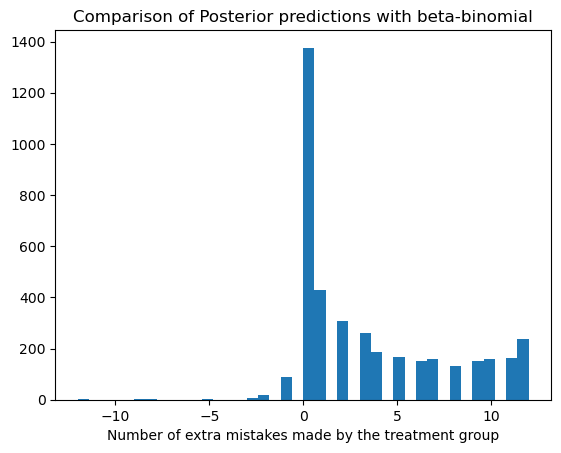

In [26]:
diffs = predictions_treatment - predictions_control

plt.hist(diffs,bins=40)
plt.title("Comparison of Posterior predictions with beta-binomial")
plt.xlabel("Number of extra mistakes made by the treatment group")
sum(diffs <= 0) / 1000000

What does all this mean? The bulk of the predictions put the two groups either making the same number of mistakes or the treatment group makes more. So it is consistent with Asch's claim that the quantitive results are clear. However, what we've added is a greater level of rigor to that claim. Now we've constructed a highly plausible model, motivated by qualitative evidence, and methodically estimated it parameters + uncertainty around those values. Once we do all this, we can demonstrate Asch's claim instead of just leaning on a hunch.

# The general guide to estimation

There is an sad truth about modeling and estimation. There is no general estimation algorithm that works for every dataset or model. Different estimation algorithms work better for some models but not for others. 

For example, in Unit 1, we learned how to build our own probability distributions just by simulating large batches of experiments. This is great for creativity - there are very few limits on what we can do and it is fairly easy to write a model that matches our imagination. But our resulting models tend to be slow. Estimating even a single parameter can be tough when we need to work through a grid of 50 possible parameter values and run 10,000 experiments at each point on the grid. 500,000 simulated experiments is a lot of computation. So if we want to estimate custom built, creative but inelegant code, we need to be really careful. pymc won't accept these sorts of models because MCMC methods tend to be unstable and extremely slow on them. Pymc is only going to accept the typical ones: binomial, beta-binomial, 
normal, and student's T distribution (a distribution we'll meet next week).

However, in Unit 1, we also learned that many custom distributions can be approximated by some of the typical distributions. If your model assume Lady Bristol gets better or worse over time, then it turns out that just equivalent to some binomial distribution. So we can often start off with custom distributions and then switch over to a fast, computationally efficient distribution later.

So instead of one universal tool for building and estimating models, we are left with a rough meagerie of tools. Here is how you should think through your own problems:

1. Is there a named distribution (binomial, beta-binomial, normal, student's T distribution) that matches your theory about the experimental data? If so, use pymc to estimate its parameters. This is best practice because we get a perfect quantification of the uncertainty in our estimates.


2. If not, then build a custom distribution.

    2.1. Is there only one parameter of interest you need to estimate? If yes, use a grid approximation. We get to keep quantifying uncertainty. But the method is fragile and restrictive.
    
    2.2. If no, then you can just hand estimate the model across all its parameters. Adjust parameters until you find the best fit and cannot improve it any more. If you have to take this route, you lose the ability to talk clearly about uncertainty.
